In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('./../data/data.csv')

In [3]:
# 1. Handle outliers
def cap_outliers(df, column, method='iqr'):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

# Apply to high-outlier columns
for col in ['Income', 'Rent', 'Disposable_Income']:
    data = cap_outliers(data, col)

# 2. Create new features
data['Savings_Rate_Actual'] = (data['Disposable_Income'] / data['Income']) * 100
data['Expense_to_Income_Ratio'] = ((data['Income'] - data['Disposable_Income']) / data['Income']) * 100
data['Rent_to_Income_Ratio'] = (data['Rent'] / data['Income']) * 100
data['Financial_Health_Score'] = np.where(data['Disposable_Income'] > 0, 
                                        (data['Disposable_Income'] / data['Income']) * 100, 0)

print("New features created:")
print(data[['Savings_Rate_Actual', 'Expense_to_Income_Ratio', 'Rent_to_Income_Ratio', 'Financial_Health_Score']].describe())

New features created:
       Savings_Rate_Actual  Expense_to_Income_Ratio  Rent_to_Income_Ratio  \
count         20000.000000             20000.000000          20000.000000   
mean             25.316413                74.683587             21.871553   
std               9.420360                 9.420360              5.319661   
min              -6.237779                49.705583             15.000000   
25%              19.150375                67.908313             20.000000   
50%              26.860041                73.139959             20.000000   
75%              32.091687                80.849625             30.000000   
max              50.294417               106.237779             30.000000   

       Financial_Health_Score  
count            20000.000000  
mean                25.326219  
std                  9.392387  
min                  0.000000  
25%                 19.150375  
50%                 26.860041  
75%                 32.091687  
max                 50.29441

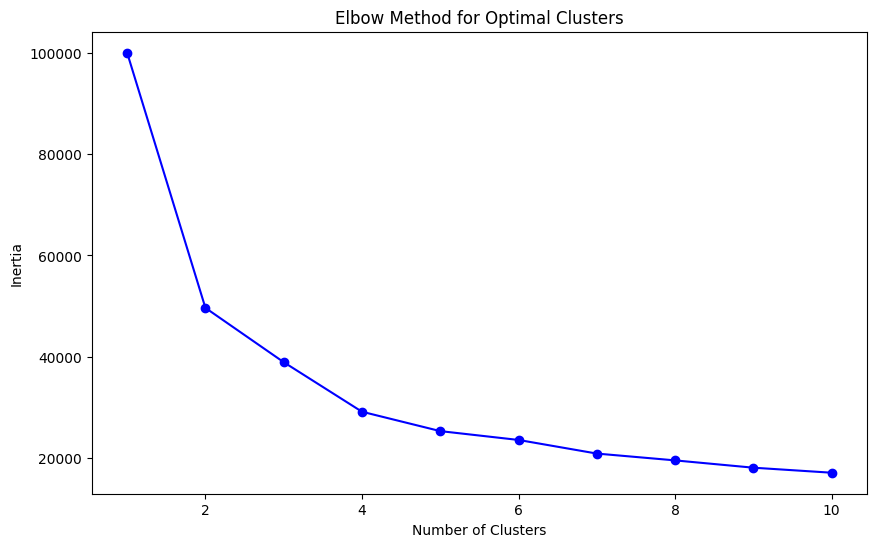

Customer Segments Analysis:
                        Income        Age          Rent  Disposable_Income  \
Customer_Segment                                                             
0                 21686.907709  29.306568   4743.405078        5457.156505   
1                 57360.816353  41.266452  12522.025837       14373.733566   
2                 97895.440626  40.976098  20726.641291       24720.156253   
3                 21659.183712  53.135425   4761.335818        5404.447590   

                  Desired_Savings_Percentage  
Customer_Segment                              
0                                   7.559012  
1                                  12.445863  
2                                  17.688558  
3                                   7.536166  


In [6]:
# 3. Customer Segmentation using clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select features for clustering
cluster_features = ['Income', 'Age', 'Rent', 'Disposable_Income', 'Desired_Savings_Percentage']
X = data[cluster_features].fillna(0)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Find optimal clusters using elbow method
inertias = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

# Apply K-means with optimal clusters (let's say 4)
kmeans = KMeans(n_clusters=4, random_state=42)
data['Customer_Segment'] = kmeans.fit_predict(X_scaled)

# Analyze segments
print("Customer Segments Analysis:")
print(data.groupby('Customer_Segment')[cluster_features].mean())

Savings Success Prediction Results:
              precision    recall  f1-score   support

           0       0.78      0.57      0.65       129
           1       0.99      0.99      0.99      3871

    accuracy                           0.98      4000
   macro avg       0.88      0.78      0.82      4000
weighted avg       0.98      0.98      0.98      4000



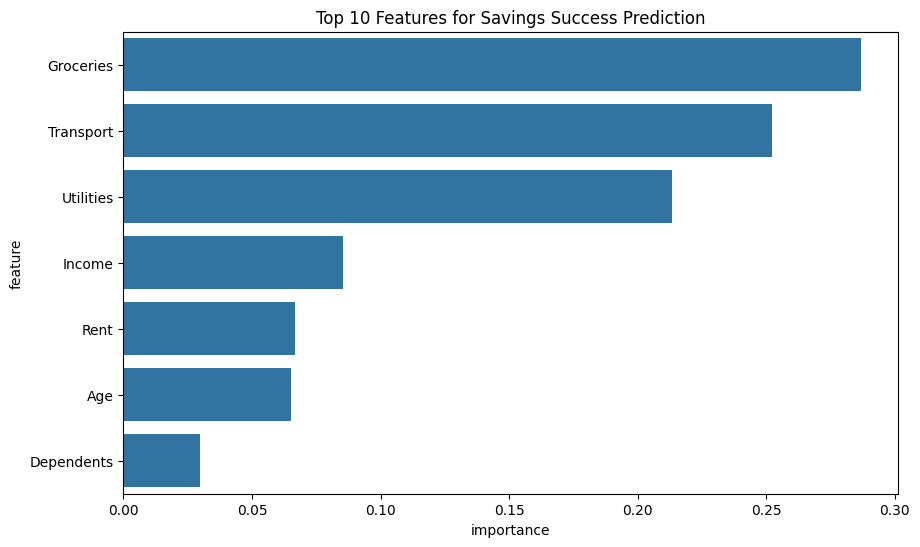

In [7]:
# 4. Predict Savings Success
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Create target variable
data['Savings_Success'] = np.where(data['Disposable_Income'] >= data['Desired_Savings'], 1, 0)

# Prepare features
feature_cols = ['Income', 'Age', 'Dependents', 'Rent', 'Groceries', 'Transport', 'Utilities']
X = data[feature_cols]
y = data['Savings_Success']

# Encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Train model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

print("Savings Success Prediction Results:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Features for Savings Success Prediction')
plt.show()

In [8]:
# 5. Create actionable insights
def financial_health_analysis():
    # Identify at-risk customers
    at_risk = data[data['Disposable_Income'] < 0]
    high_potential = data[(data['Income'] > data['Income'].median()) & 
                         (data['Disposable_Income'] > data['Desired_Savings'])]
    
    print(f"At-Risk Customers: {len(at_risk)} ({len(at_risk)/len(data)*100:.1f}%)")
    print(f"High-Potential Customers: {len(high_potential)} ({len(high_potential)/len(data)*100:.1f}%)")
    
    # Savings optimization recommendations
    print("\nSavings Optimization Opportunities:")
    potential_savings_cols = [col for col in data.columns if 'Potential_Savings' in col]
    for col in potential_savings_cols:
        avg_potential = data[col].mean()
        print(f"{col.replace('Potential_Savings_', '')}: ${avg_potential:.2f} average potential savings")

financial_health_analysis()

At-Risk Customers: 112 (0.6%)
High-Potential Customers: 8484 (42.4%)

Savings Optimization Opportunities:
Groceries: $912.20 average potential savings
Transport: $473.04 average potential savings
Eating_Out: $254.96 average potential savings
Entertainment: $254.03 average potential savings
Utilities: $436.33 average potential savings
Healthcare: $41.52 average potential savings
Education: $62.42 average potential savings
Miscellaneous: $144.90 average potential savings


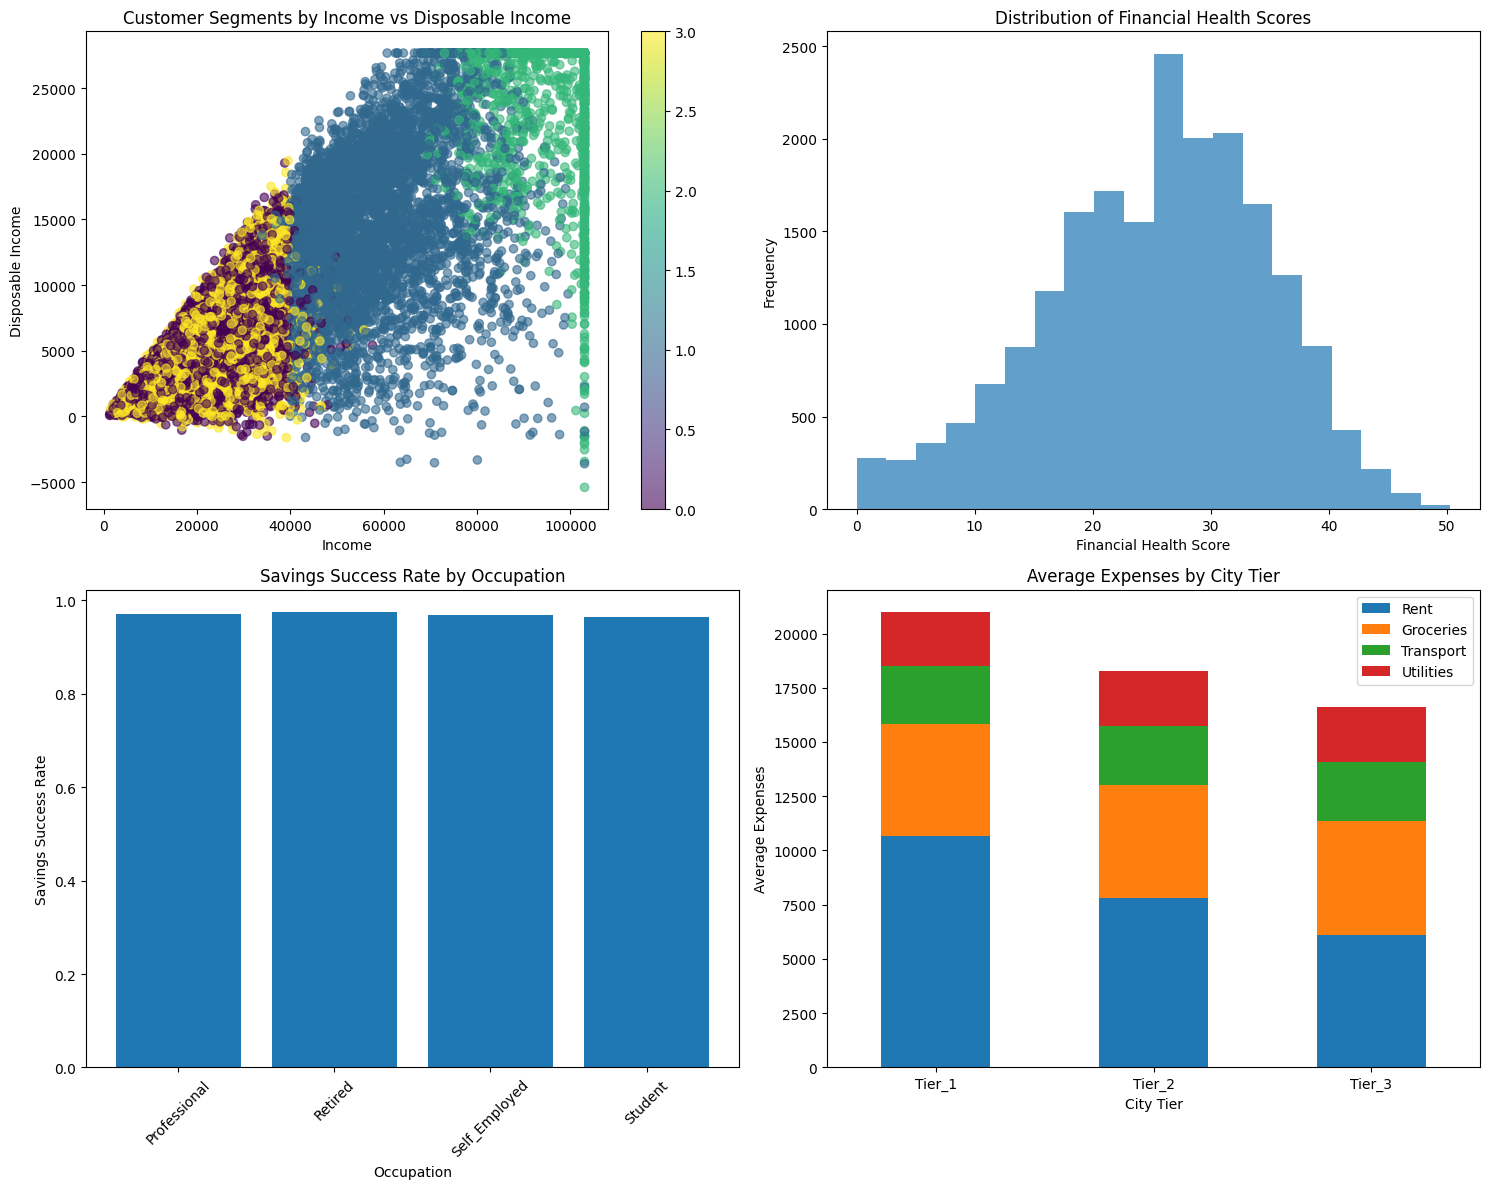

In [9]:
# 6. Create comprehensive dashboard
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Customer segments by income and savings
scatter = axes[0,0].scatter(data['Income'], data['Disposable_Income'], 
                           c=data['Customer_Segment'], cmap='viridis', alpha=0.6)
axes[0,0].set_xlabel('Income')
axes[0,0].set_ylabel('Disposable Income')
axes[0,0].set_title('Customer Segments by Income vs Disposable Income')
plt.colorbar(scatter, ax=axes[0,0])

# Financial health distribution
axes[0,1].hist(data['Financial_Health_Score'], bins=20, alpha=0.7)
axes[0,1].set_xlabel('Financial Health Score')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Distribution of Financial Health Scores')

# Savings goal achievement by occupation
savings_success_by_occ = data.groupby('Occupation')['Savings_Success'].mean()
axes[1,0].bar(savings_success_by_occ.index, savings_success_by_occ.values)
axes[1,0].set_xlabel('Occupation')
axes[1,0].set_ylabel('Savings Success Rate')
axes[1,0].set_title('Savings Success Rate by Occupation')
axes[1,0].tick_params(axis='x', rotation=45)

# Expense breakdown by city tier
expense_cols = ['Rent', 'Groceries', 'Transport', 'Utilities']
city_expenses = data.groupby('City_Tier')[expense_cols].mean()
city_expenses.plot(kind='bar', ax=axes[1,1], stacked=True)
axes[1,1].set_xlabel('City Tier')
axes[1,1].set_ylabel('Average Expenses')
axes[1,1].set_title('Average Expenses by City Tier')
axes[1,1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()